In [2]:
import sys, os
import numpy as np
import time, h5py
codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import default_paths, nsd_utils, numpy_utils, stats_utils
from model_fitting import initialize_fitting 
import argparse
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import scipy.stats
import cmocean

from plotting import load_fits

In [3]:

subject =1;
discrim_type_list =['animacy','indoor_outdoor', 'person', 'animal','food','vehicle']
corr_result_list = [];
dprime_result_list = [];
which_prf_grid = 5
models = initialize_fitting.get_prf_models(which_grid=which_prf_grid)
n_prfs = len(models)

path_to_load = default_paths.gabor_texture_feat_path
fn1 = os.path.join(path_to_load, 'S%d_mean_grid%d.npy'%(subject, which_prf_grid))
fn2 = os.path.join(path_to_load, 'S%d_var_grid%d.npy'%(subject, which_prf_grid))
fn3 = os.path.join(path_to_load, 'S%d_covar_grid%d.npy'%(subject, which_prf_grid))
print('loading from %s and %s and %s'%(fn1, fn2, fn3))
mean_result = np.load(fn1,allow_pickle=True)
var_result = np.load(fn2,allow_pickle=True)
covar_result = np.load(fn3,allow_pickle=True)
path_to_load = os.path.join(path_to_load, 'semantic_discrim')
for dd, discrim_type in enumerate(discrim_type_list):
    fn1 = os.path.join(path_to_load, 'S%d_corrs_%s_grid%d.npy'%(subject, discrim_type, which_prf_grid))
    fn2 = os.path.join(path_to_load, 'S%d_dprime_%s_grid%d.npy'%(subject, discrim_type, which_prf_grid))
    print('loading from %s and %s'%(fn1, fn2))
    corr_result = np.load(fn1,allow_pickle=True)
    dprime_result = (-1)*np.load(fn2,allow_pickle=True)
    corr_result_list.append(corr_result)
    dprime_result_list.append(dprime_result)
    corr_result=None; dprime_result=None

number of pRFs: 1456
most extreme RF positions:
[2.7755576e-17 0.0000000e+00 2.0000000e-02]
[ 0.7698996  -0.31890285  1.        ]
loading from /user_data/mmhender/features/gabor_texture/S1_mean_grid5.npy and /user_data/mmhender/features/gabor_texture/S1_var_grid5.npy and /user_data/mmhender/features/gabor_texture/S1_covar_grid5.npy
loading from /user_data/mmhender/features/gabor_texture/semantic_discrim/S1_corrs_animacy_grid5.npy and /user_data/mmhender/features/gabor_texture/semantic_discrim/S1_dprime_animacy_grid5.npy
loading from /user_data/mmhender/features/gabor_texture/semantic_discrim/S1_corrs_indoor_outdoor_grid5.npy and /user_data/mmhender/features/gabor_texture/semantic_discrim/S1_dprime_indoor_outdoor_grid5.npy
loading from /user_data/mmhender/features/gabor_texture/semantic_discrim/S1_corrs_person_grid5.npy and /user_data/mmhender/features/gabor_texture/semantic_discrim/S1_dprime_person_grid5.npy
loading from /user_data/mmhender/features/gabor_texture/semantic_discrim/S1_co

In [4]:

subject = 1
volume_space=True
fitting_type = 'gabor_solo_ridge_12ori_8sf'
# fitting_type='gabor_pca_max100dim'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, \
                                                  n_from_end=0, root=root, verbose=True);
# load_fits.print_output_summary(out)

w = out['best_params'][1][:,:,0]

feature_corrs = out['corr_each_feature']

cyc_per_stim = np.array(out['feature_table_complex']['SF: cycles per stim'])
# cyc_per_stim = np.unique(cyc_per_stim)
screen_eccen_deg=8.4
cyc_per_deg = cyc_per_stim/screen_eccen_deg
sf_vals_cyc_per_deg, sf_inds = np.unique(cyc_per_deg, return_inverse=True)

orients_deg = np.array(out['feature_table_complex']['Orientation: degrees'])
orient_vals_deg, orient_inds = np.unique(orients_deg, return_inverse=True)

feature_weights = out['best_params'][1][:,:,0]
feature_corr = out['corr_each_feature']
n_voxels = feature_weights.shape[0]
n_ori = len(np.unique(orients_deg))
n_sf = len(np.unique(cyc_per_stim))

allw_reshaped = np.reshape(feature_weights, [n_voxels, n_ori, n_sf], order='F')
mean_orient_weights = np.mean(allw_reshaped, axis=2)
print(np.shape(mean_orient_weights))
mean_sf_weights = np.mean(allw_reshaped, axis=1)
print(np.shape(mean_sf_weights))

allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
print(np.shape(mean_orient_corr))
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)
print(np.shape(mean_sf_corr))

# find maxes. if they are constant across orient/SF, then set to nan.
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1], [1,n_ori])==mean_orient_corr, axis=1)
preferred_ori_corr[is_constant] = np.nan

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
preferred_sf_corr[is_constant] = np.nan

preferred_ori_weights = np.argmax(mean_orient_weights, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_weights[:,0:1], [1,n_ori])==mean_orient_weights, axis=1)
preferred_ori_weights[is_constant] = np.nan

preferred_sf_weights = np.argmax(mean_sf_weights, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_weights[:,0:1], [1,n_sf])==mean_sf_weights, axis=1)
preferred_sf_weights[is_constant] = np.nan

loading from /user_data/mmhender/imStat/model_fits/S01/gabor_solo_ridge_12ori_8sf/Dec-10-2021_1208_11/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'corr_each_feature', 'discrim_each_axis', 'feature_table_simple', 'filter_pars_simple', 'orient_filters_simple', 'feature_table_complex', 'filter_pars_complex', 'orient_filters_complex', 'feature_types_exclude', 'gabor_feature_info', 'autocorr_output_pix', 'group_all_hl_feats', 'gabor_nonlin_fn'])
(19738, 12)
(19738, 8)
(19738, 12)
(19738, 8)


In [5]:
# Get ROI information/labels

from utils import roi_utils
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 
skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def
roi_names = ret_names+face_names+place_names+body_names
nret = len(ret_names)
nface = len(face_names)
nplace = len(place_names)
nbody = len(body_names)    
n_rois = len(ret_names) + len(face_names) + len(place_names) + len(body_names)

is_ret = np.arange(0, n_rois)<nret
is_face = (np.arange(0, n_rois)>=nret) & (np.arange(0, n_rois)<nret+nface)
is_place = (np.arange(0, n_rois)>=nret+nface) & (np.arange(0, n_rois)<nret+nface+nplace)
is_body = np.arange(0, n_rois)>=nret+nface+nplace


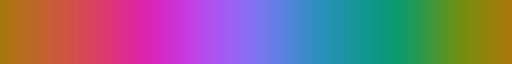

In [8]:

cmocean.cm.phase

[-0.07967252284288406, 0.2743244171142578]
[-0.3644197065944141, 0.7746673123838874]


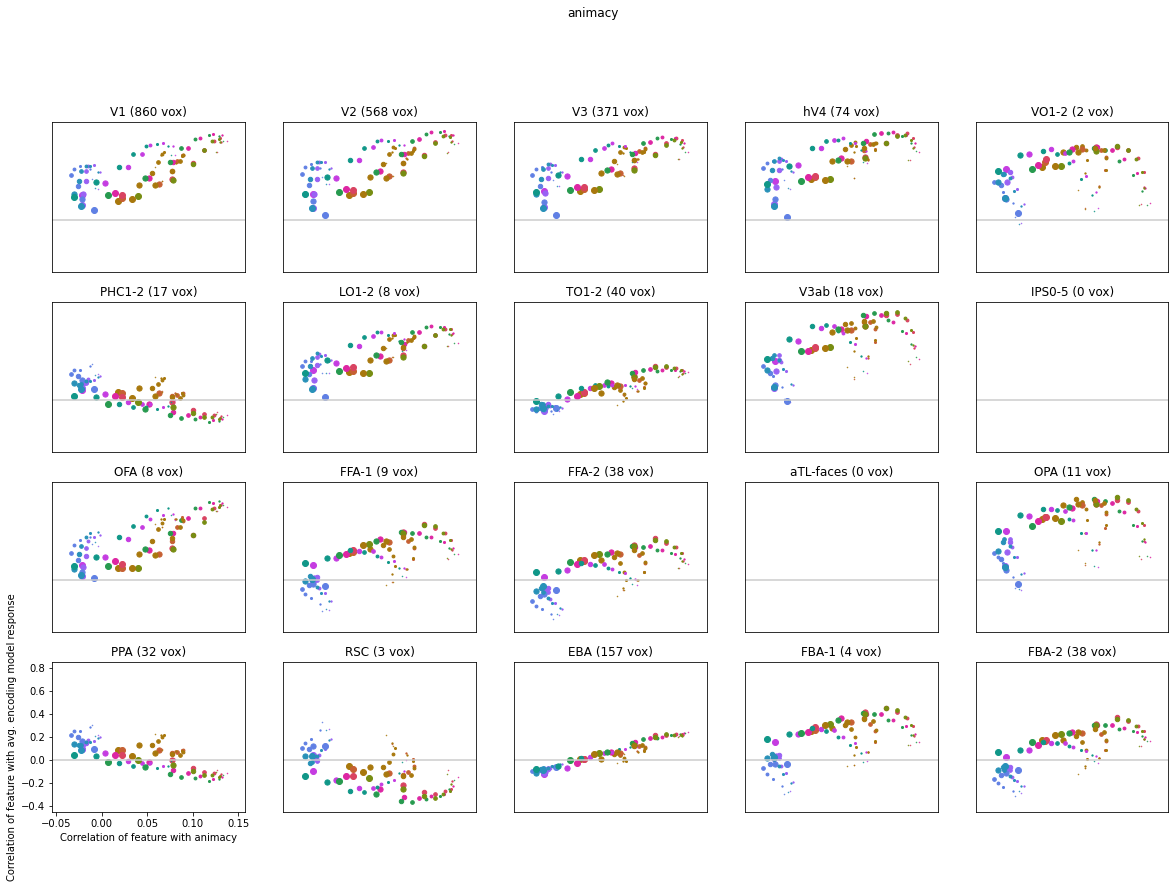

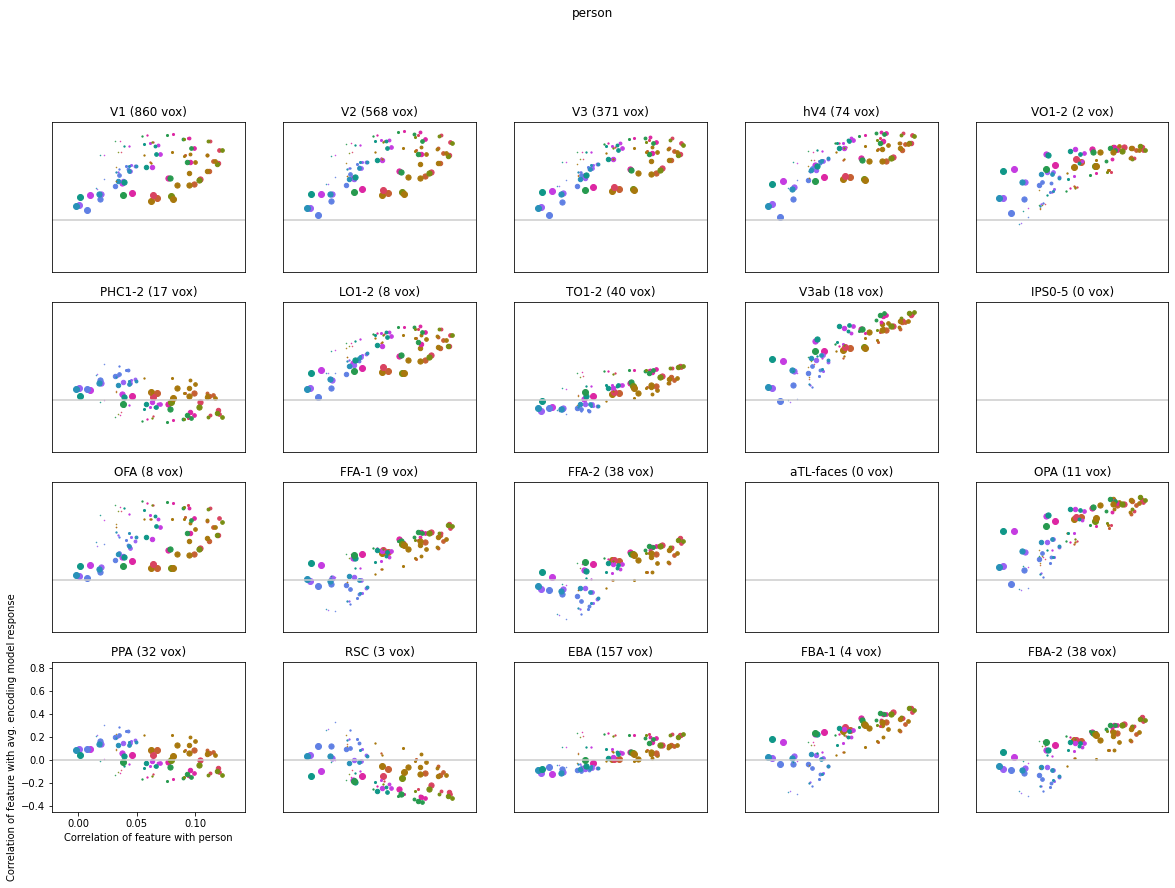

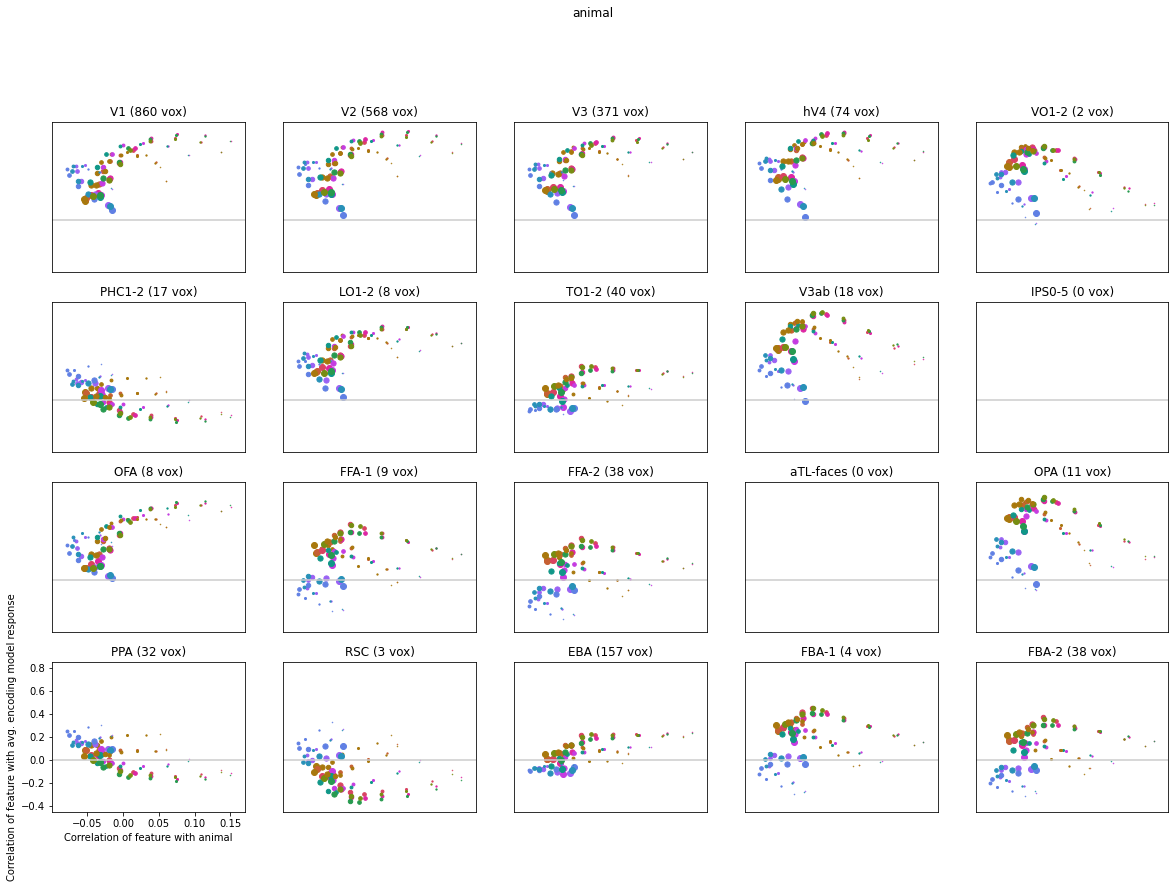

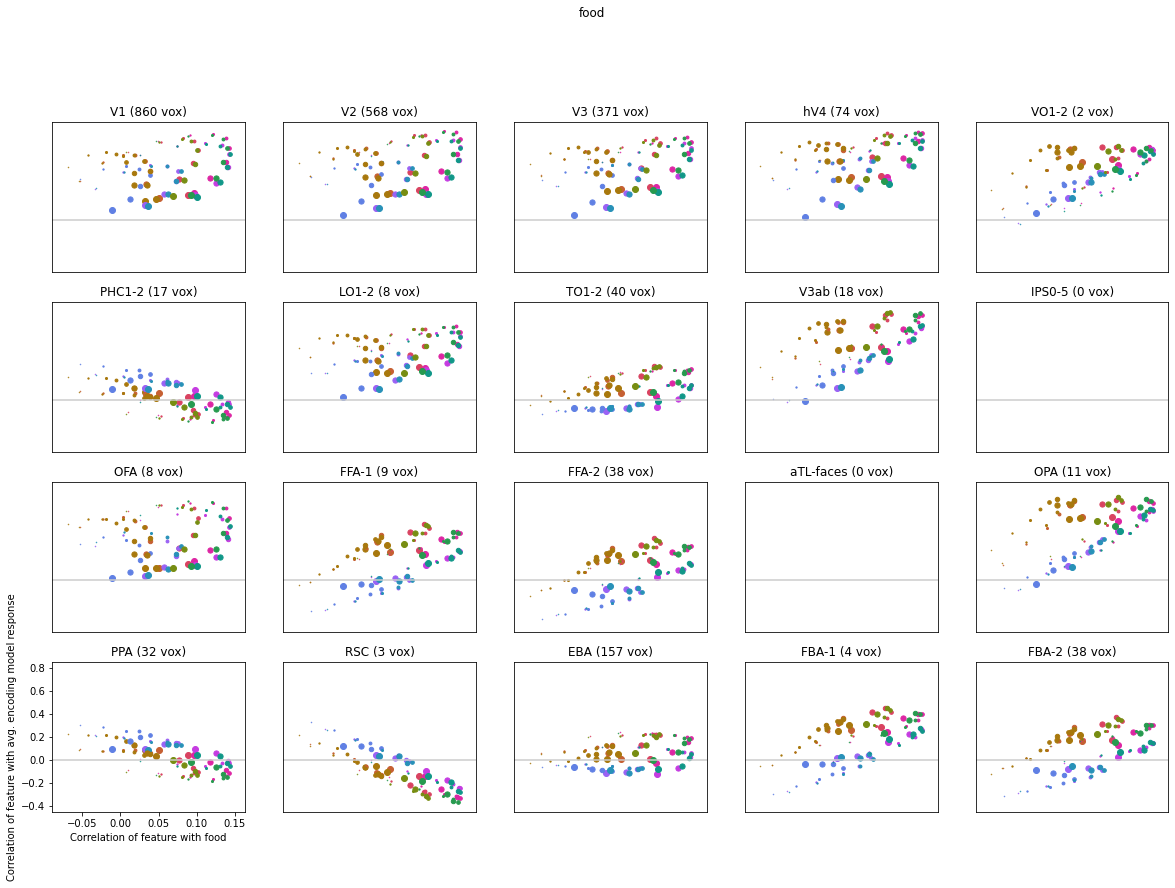

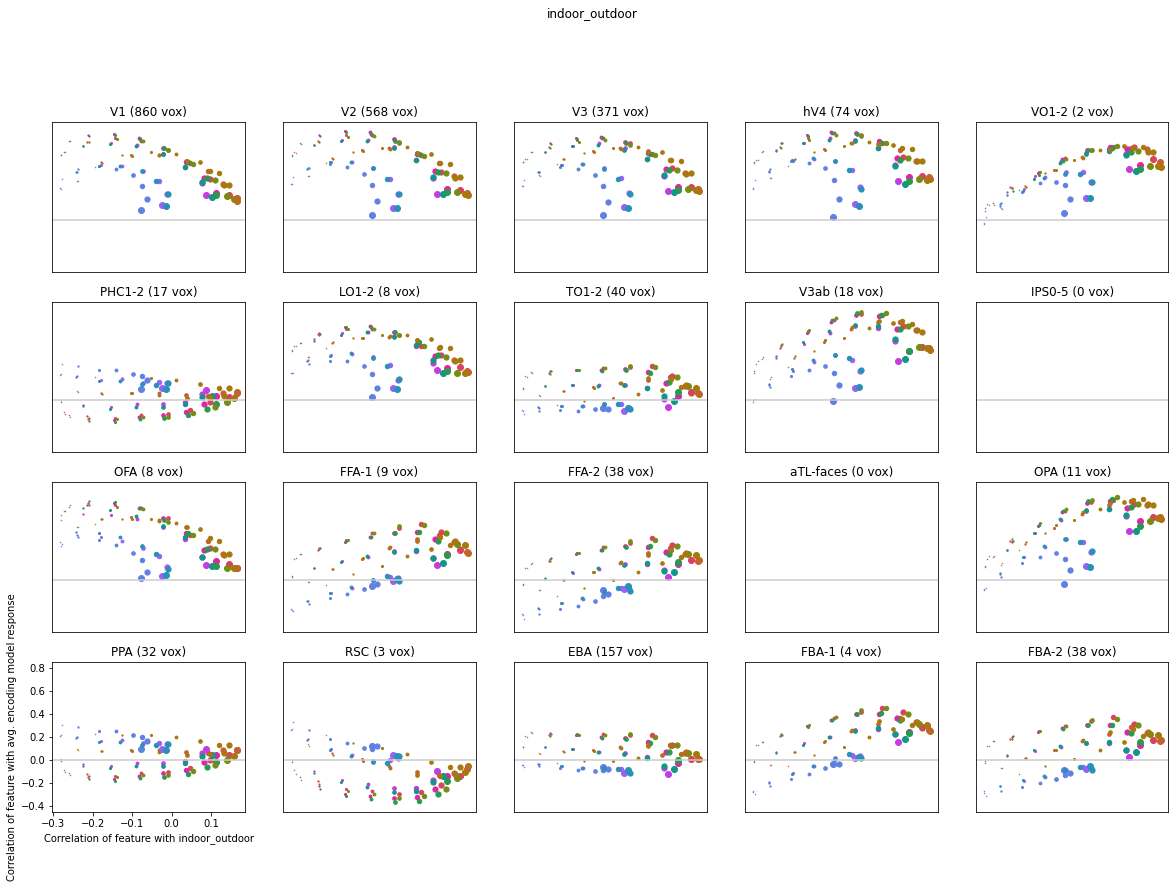

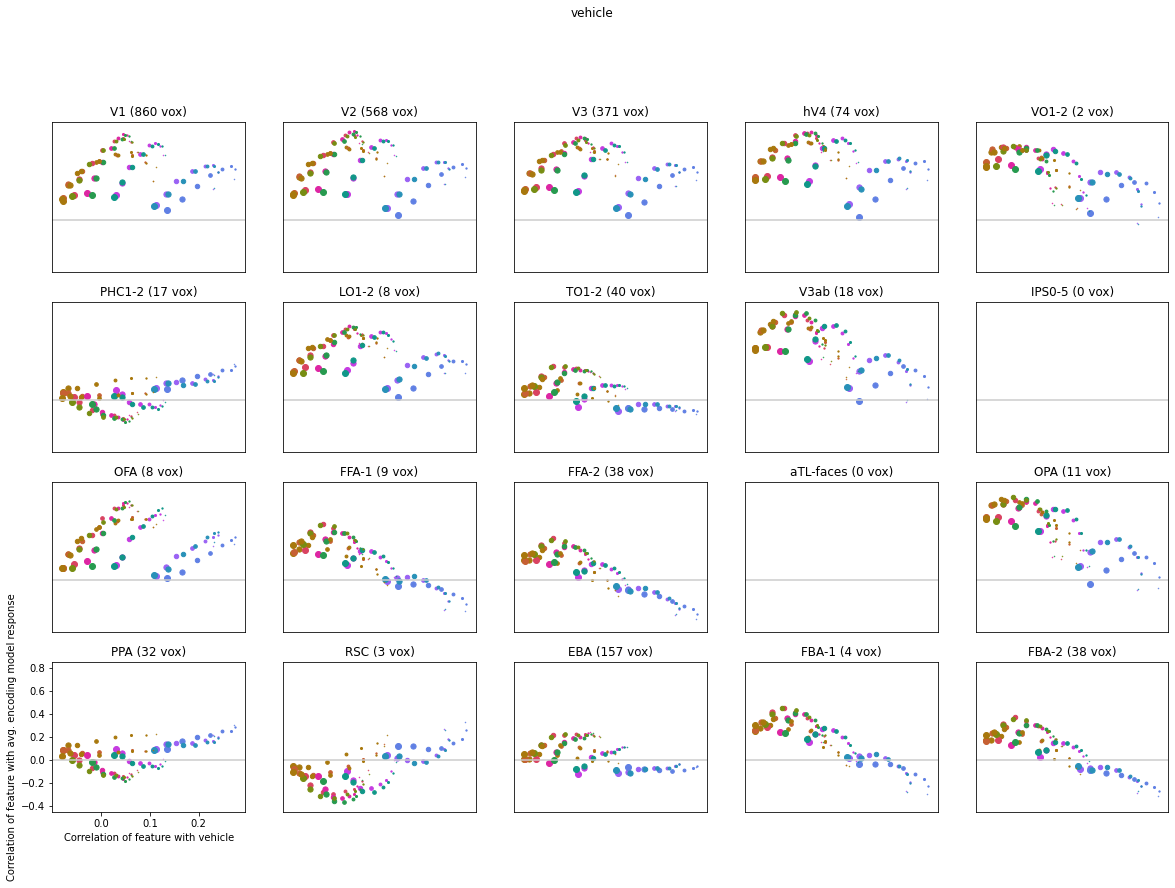

In [19]:
# Plot relationship between feature channels' semantic content, and their correlation w 
# voxel responses in each ROI.

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff


n_color_steps = n_ori
# colors = cm.plasma(np.linspace(0,1,n_color_steps))
colors = cmocean.cm.phase(np.linspace(0,1,n_color_steps))


n_size_steps = n_sf
sizes = np.linspace(12,1,n_sf)
# sizes = np.linspace(12,12,n_sf)

dorder = [0,2,3,4,1,5]

for dd in dorder:

    xlims = [np.min(np.mean(corr_result_list[dd], axis=1))-0.02, \
             np.max(np.mean(corr_result_list[dd], axis=1))+0.02]
    ylims = [-0.45, 0.85]
    
    plt.figure(figsize=(20,16))
    npx = int(np.ceil(np.sqrt(n_rois)))
    npy = int(np.ceil(n_rois/npx))

    pi=0
    running_xmin=100; running_ymin=100;
    running_xmax=-100; running_ymax=-100;
    for rr in range(n_rois):

        if rr not in skip_inds:
            if is_ret[rr]:
                inds_this_roi = retlabs==rr
                rname = ret_names[rr]
            elif is_face[rr]:
                inds_this_roi = facelabs==(rr-nret)
                rname = face_names[rr-nret]
            elif is_place[rr]:
                inds_this_roi = placelabs==(rr-nret-nface)
                rname = place_names[rr-nret-nface]
            elif is_body[rr]:
                inds_this_roi = bodylabs==(rr-nret-nface-nplace)
                rname = body_names[rr-nret-nface-nplace]

            inds_this_roi = inds_this_roi & abv_thresh
            
            pi+=1
            plt.subplot(npx,npy,pi)
            
            if np.sum(inds_this_roi)>0:   
                xvals = np.mean(corr_result_list[dd], axis=1)
                yvals = np.mean(feature_corrs[inds_this_roi,:], axis=0)
                running_xmin = np.min([running_xmin, np.min(xvals)])
                running_ymin = np.min([running_ymin, np.min(yvals)])
                running_xmax = np.max([running_xmax, np.max(xvals)])
                running_ymax = np.max([running_ymax, np.max(yvals)])

                for oo in range(n_ori):
#                     inds = np.where(orient_inds==oo)[0]
#                     plt.plot(np.mean(xvals[inds]), np.mean(yvals[inds]), '.',\
#                              color=colors[oo,:], markersize=sizes[sf])
                    for sf in range(n_sf):
                        inds = np.where((orient_inds==oo) & (sf_inds==sf))[0]
                        plt.plot(xvals[inds], yvals[inds],'.',color=colors[oo,:], markersize=sizes[sf])
            if pi==n_rois-8:
                plt.xlabel('Correlation of feature with %s'%discrim_type_list[dd])
                plt.ylabel('Correlation of feature with avg. encoding model response')
            else:
                plt.xticks([])
                plt.yticks([])

            plt.axhline(0,color=[0.8, 0.8, 0.8])
            plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

            plt.xlim(xlims)
            plt.ylim(ylims)

    
    plt.suptitle(discrim_type_list[dd]);
    
print([running_xmin, running_xmax])
print([running_ymin, running_ymax])


[0.00012841033458244056, 0.0012888727942481637]
[-0.3644197065944141, 0.7746673123838874]


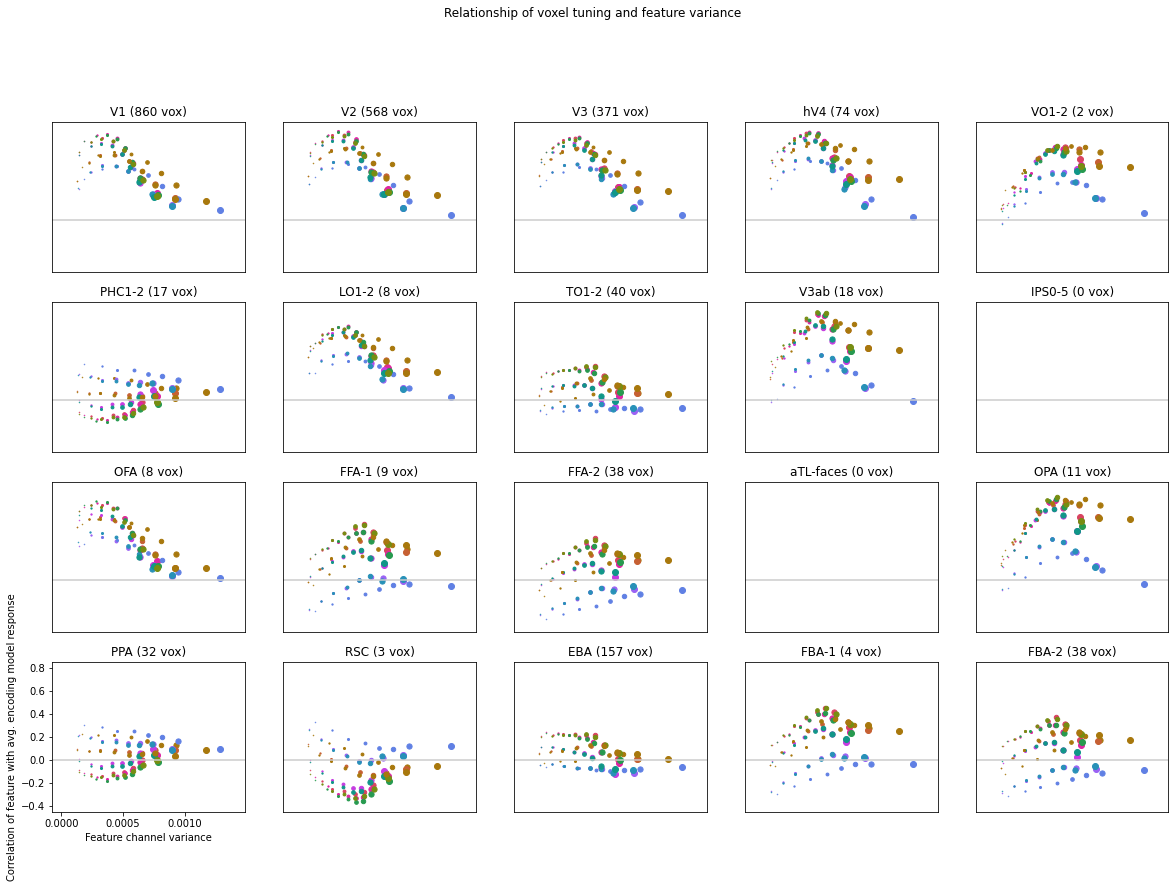

In [25]:
# Plot relationship between feature channels' variance, and their correlation w 
# voxel responses in each ROI.

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff

n_color_steps = n_ori
# colors = cm.plasma(np.linspace(0,1,n_color_steps))
colors = cmocean.cm.phase(np.linspace(0,1,n_color_steps))

n_size_steps = n_sf
sizes = np.linspace(12,1,n_sf)
# sizes = np.linspace(12,12,n_sf)

xlims = [np.min(np.mean(var_result, axis=1))-0.0002, \
         np.max(np.mean(var_result, axis=1))+0.0002]
ylims = [-0.45, 0.85]

plt.figure(figsize=(20,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

pi=0
running_xmin=100; running_ymin=100;
running_xmax=-100; running_ymax=-100;
for rr in range(n_rois):

    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
            rname = ret_names[rr]
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
            rname = face_names[rr-nret]
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
            rname = place_names[rr-nret-nface]
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            rname = body_names[rr-nret-nface-nplace]

        inds_this_roi = inds_this_roi & abv_thresh

        pi+=1
        plt.subplot(npx,npy,pi)

        if np.sum(inds_this_roi)>0:   
            xvals = np.mean(var_result, axis=1)
            yvals = np.mean(feature_corrs[inds_this_roi,:], axis=0)
            running_xmin = np.min([running_xmin, np.min(xvals)])
            running_ymin = np.min([running_ymin, np.min(yvals)])
            running_xmax = np.max([running_xmax, np.max(xvals)])
            running_ymax = np.max([running_ymax, np.max(yvals)])

            for oo in range(n_ori):
#                     inds = np.where(orient_inds==oo)[0]
#                     plt.plot(np.mean(xvals[inds]), np.mean(yvals[inds]), '.',\
#                              color=colors[oo,:], markersize=sizes[sf])
                for sf in range(n_sf):
                    inds = np.where((orient_inds==oo) & (sf_inds==sf))[0]
                    plt.plot(xvals[inds], yvals[inds],'.',color=colors[oo,:], markersize=sizes[sf])
        if pi==n_rois-8:
            plt.xlabel('Feature channel variance')
            plt.ylabel('Correlation of feature with avg. encoding model response')
        else:
            plt.xticks([])
            plt.yticks([])

        plt.axhline(0,color=[0.8, 0.8, 0.8])
        plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

        plt.xlim(xlims)
        plt.ylim(ylims)

    
plt.suptitle('Relationship of voxel tuning and feature variance');
    
print([running_xmin, running_xmax])
print([running_ymin, running_ymax])


[0.03885922208428383, 0.13691352307796478]
[-0.3644197065944141, 0.7746673123838874]


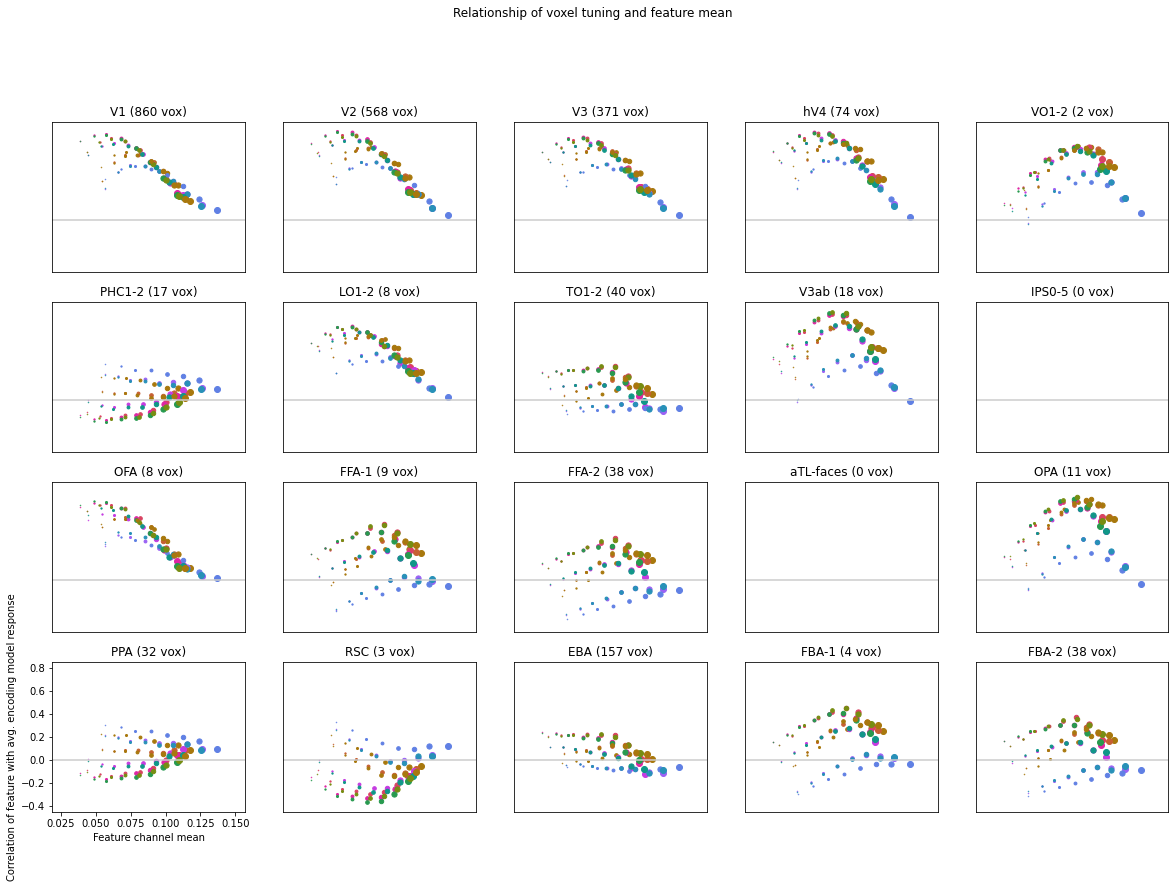

In [26]:
# Plot relationship between feature channels' mean, and their correlation w 
# voxel responses in each ROI.

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff

n_color_steps = n_ori
# colors = cm.plasma(np.linspace(0,1,n_color_steps))
colors = cmocean.cm.phase(np.linspace(0,1,n_color_steps))

n_size_steps = n_sf
sizes = np.linspace(12,1,n_sf)
# sizes = np.linspace(12,12,n_sf)

xlims = [np.min(np.mean(mean_result, axis=1))-0.02, \
         np.max(np.mean(mean_result, axis=1))+0.02]
ylims = [-0.45, 0.85]

plt.figure(figsize=(20,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

pi=0
running_xmin=100; running_ymin=100;
running_xmax=-100; running_ymax=-100;
for rr in range(n_rois):

    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
            rname = ret_names[rr]
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
            rname = face_names[rr-nret]
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
            rname = place_names[rr-nret-nface]
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            rname = body_names[rr-nret-nface-nplace]

        inds_this_roi = inds_this_roi & abv_thresh

        pi+=1
        plt.subplot(npx,npy,pi)

        if np.sum(inds_this_roi)>0:   
            xvals = np.mean(mean_result, axis=1)
            yvals = np.mean(feature_corrs[inds_this_roi,:], axis=0)
            running_xmin = np.min([running_xmin, np.min(xvals)])
            running_ymin = np.min([running_ymin, np.min(yvals)])
            running_xmax = np.max([running_xmax, np.max(xvals)])
            running_ymax = np.max([running_ymax, np.max(yvals)])

            for oo in range(n_ori):
#                     inds = np.where(orient_inds==oo)[0]
#                     plt.plot(np.mean(xvals[inds]), np.mean(yvals[inds]), '.',\
#                              color=colors[oo,:], markersize=sizes[sf])
                for sf in range(n_sf):
                    inds = np.where((orient_inds==oo) & (sf_inds==sf))[0]
                    plt.plot(xvals[inds], yvals[inds],'.',color=colors[oo,:], markersize=sizes[sf])
        if pi==n_rois-8:
            plt.xlabel('Feature channel mean')
            plt.ylabel('Correlation of feature with avg. encoding model response')
        else:
            plt.xticks([])
            plt.yticks([])

        plt.axhline(0,color=[0.8, 0.8, 0.8])
        plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

        plt.xlim(xlims)
        plt.ylim(ylims)

    
plt.suptitle('Relationship of voxel tuning and feature mean');
    
print([running_xmin, running_xmax])
print([running_ymin, running_ymax])


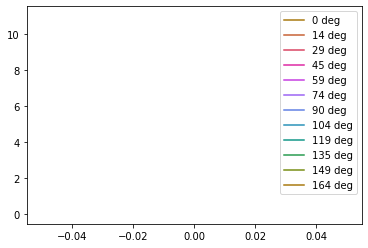

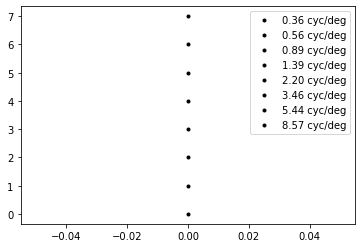

In [17]:
plt.figure();
for oo in range(n_ori):
    plt.plot(0,oo,color=colors[oo,:])    
plt.legend(['%d deg'%orient_vals_deg[oo] for oo in range(n_ori)])

plt.figure();
for sf in range(n_sf):
    plt.plot(0,sf,'.',markersize=sizes[sf],color='k')    
plt.legend(['%.2f cyc/deg'%sf_vals_cyc_per_deg[sf] for sf in range(n_sf)])

Text(0.5, 0.98, 'Number of voxels all areas with this pRF')

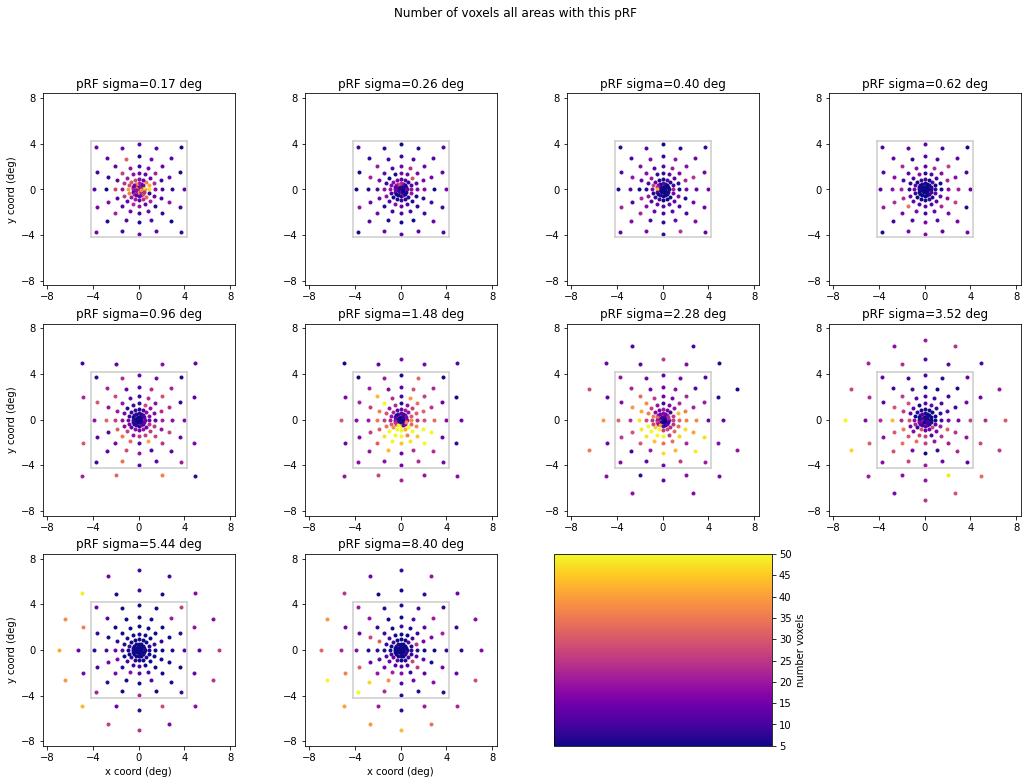

In [5]:
prf_models = models
neach = np.array([np.sum(out['best_params'][5][:,0]==mm) for mm in range(n_prfs)])
unique_sizes = np.unique(np.round(prf_models[:,2],4))

fig = plt.figure(figsize=(18,12));

n_color_steps = np.max(neach)
colors = cm.plasma(np.linspace(0,1,n_color_steps))
# vals_range = [np.min(neach), \
#                 np.max(neach)]
vals_range = [5,50]
vals_steps = np.linspace(vals_range[0], vals_range[1], n_color_steps)
screen_eccen_deg = 8.4
xylims = 1.0*screen_eccen_deg

for si, size in enumerate(unique_sizes):

    inds = np.where(np.round(prf_models[:,2],4)==size)[0]

    prf_models_plot = models[inds,:]
    vals_plot = neach[inds]
#     dprime_plot = np.array(lda_result['val_dprime'])[inds]
    plt.subplot(3,4,si+1)
    ax = plt.gca()
        
    for mm in range(len(prf_models_plot)):
        x,y,sigma = prf_models_plot[mm,:]
#         dprime = dprime_plot[mm]
        val = vals_plot[mm]
        color_ind = np.argmin(np.abs(vals_steps-val))
#         print(colors[color_ind,:])
        plt.plot(x*screen_eccen_deg,y*screen_eccen_deg,'.', color=colors[color_ind,:])  
        
    plt.axis('square')
    plt.xlim([-xylims, xylims])
    plt.ylim([-xylims, xylims])
    plt.xticks(np.arange(-8,9,4))
    plt.yticks(np.arange(-8,9,4))
    
    plt.plot([screen_eccen_deg/2,screen_eccen_deg/2], [screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,-screen_eccen_deg/2], [screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], [screen_eccen_deg/2, screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], [-screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])

    if si>7:
        plt.xlabel('x coord (deg)')
    if np.mod(si,4)==0:
        plt.ylabel('y coord (deg)')

    plt.title('pRF sigma=%.2f deg'%(size*screen_eccen_deg))
    
ax = plt.subplot(3,4,si+2)
scalmap = cm.ScalarMappable(matplotlib.colors.Normalize(vmin=vals_range[0], vmax=vals_range[1]),\
                  cmap='plasma')
fig.colorbar(scalmap, orientation='vertical', label='number voxels',cax=ax)

plt.suptitle('Number of voxels all areas with this pRF')

Text(0.5, 1.0, 'eccen values')

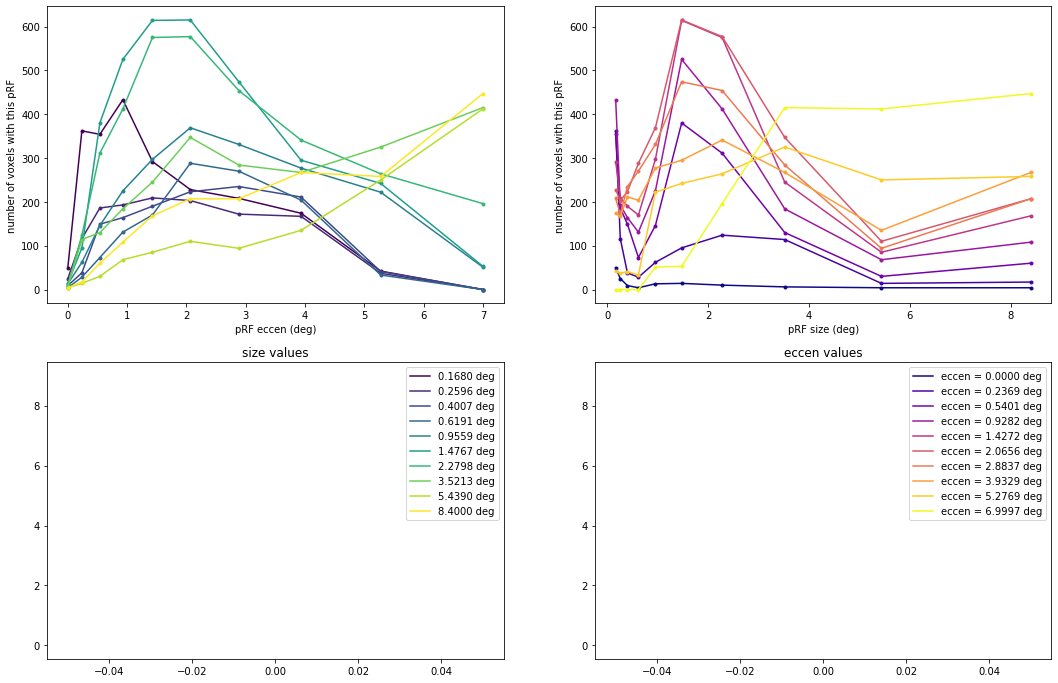

In [33]:
prf_models = models
neach = np.array([np.sum(out['best_params'][5][:,0]==mm) for mm in range(n_prfs)])
unique_sizes, size_inds = np.unique(np.round(prf_models[:,2],4), return_inverse=True)
eccens = np.sqrt(prf_models[:,0]**2+prf_models[:,1]**2)
unique_eccens, eccen_inds = np.unique(np.round(eccens,4), return_inverse=True)

neach_size_by_eccen = np.array([[np.sum(neach[(size_inds==si) & (eccen_inds==ei)]) \
                        for ei in range(len(unique_eccens))] for si in range(len(unique_sizes))])

fig = plt.figure(figsize=(18,12));

eccen_colors = cm.plasma(np.linspace(0,1,len(unique_eccens)))
size_colors = cm.viridis(np.linspace(0,1,len(unique_sizes)))

plt.subplot(2,2,1)
for si, size in enumerate(unique_sizes):

    xvals = unique_eccens*8.4
    yvals = neach_size_by_eccen[si,:]
    
    plt.plot(xvals, yvals, '.-',color=size_colors[si,:])
    plt.xlabel('pRF eccen (deg)')
    plt.ylabel('number of voxels with this pRF')

plt.subplot(2,2,2)
for ei, ecc in enumerate(unique_eccens):

    xvals = unique_sizes*8.4
    yvals = neach_size_by_eccen[:,ei]
    
    
    plt.plot(xvals, yvals, '.-', color=eccen_colors[ei,:])
    plt.xlabel('pRF size (deg)')
    plt.ylabel('number of voxels with this pRF')
    
plt.subplot(2,2,3)
for ss in range(len(unique_sizes)):
        plt.plot(0,ss,color=size_colors[ss,:])    
plt.legend(['%.4f deg'%(unique_sizes[ss]*8.4) for ss in range(len(unique_sizes))])
plt.title('size values')

plt.subplot(2,2,4)
for ee in range(len(unique_eccens)):
    plt.plot(0,ee,color=eccen_colors[ee,:])    
plt.legend(['eccen = %.4f deg'%(unique_eccens[ee]*8.4) for ee in range(len(unique_eccens))])
plt.title('eccen values')



In [13]:
size_inds.shape

(1456,)

In [11]:
xvals

array([0.9558881, 0.9558881, 0.9558881, 0.9558881, 1.4763234, 1.4763234,
       1.4763234, 1.4763234, 2.2801106, 2.2801106, 2.2801106, 2.2801106,
       2.2801106, 2.2801106, 2.2801106, 2.2801106, 2.2801106, 2.2801106,
       2.2801106, 2.2801106, 3.5215218, 3.5215218, 3.5215218, 3.5215218,
       3.5215218, 3.5215218, 3.5215218, 3.5215218, 3.5215218, 3.5215218,
       3.5215218, 3.5215218, 3.5215218, 3.5215218, 3.5215218, 3.5215218,
       5.438822 , 5.438822 , 5.438822 , 5.438822 , 5.438822 , 5.438822 ,
       5.438822 , 5.438822 , 5.438822 , 5.438822 , 5.438822 , 5.438822 ,
       5.438822 , 5.438822 , 5.438822 , 5.438822 , 8.4      , 8.4      ,
       8.4      , 8.4      , 8.4      , 8.4      , 8.4      , 8.4      ,
       8.4      , 8.4      , 8.4      , 8.4      , 8.4      , 8.4      ,
       8.4      , 8.4      ], dtype=float32)

In [61]:
dprime_result.shape

(96, 1456)